In [79]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [3]:
df = pd.read_csv('./data/weatherAUS.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
# Задание 4.1
# Сколько суммарно пропусков в данных?
df.isna().sum().sum()


343248

In [7]:
# Задание 4.2
# В некоторых признаках пропусков более 40 % - удалите такие признаки. Сколько их было?

empty_data = df.isna().mean()*100
drop_list = []
for i, j in zip(empty_data.index, empty_data.values):
    if j >= 40:
        drop_list.append(i)

df = df.drop(drop_list, axis=1)
print(len(drop_list))


3


In [8]:
# Задание 4.3
# Теперь обработаем признаки RainToday И RainTomorrow таким образом, чтобы вместо yes было значение 1, а вместо по - значение о.
# Обратите внимание на то, что в признаках RainToday И RainTomorrow присутствуют пропуски, и их трогать не нужно, они должны остаться
# пропусками. Поэтому обрабатывайте столбцы таким образом, чтобы не видоизменить пропущенные значения.
# Вычислите среднее арифметическое для преобразованного признака RainToday и запишите его в ответ, предварительно округлив до двух
# знаков после точки-разделителя.

df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

round(df['RainToday'].mean(), 2)


0.22

In [9]:
# Задание 4.4
# Обработайте признак Date таким образом, чтобы выделить в отдельный признак Month (номер месяца). Изначальный признак Date удалите.
# Определите, какой месяц имеет самую большую часть дождливых дней относительно всех дней месяца. В качестве ответа введите
# порядковый номер месяца.

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df = df.drop(['Date'], axis=1)

rainy_month = df.groupby(by='Month').mean()
print(f'Самый дождливый месяц: {rainy_month["RainToday"].idxmax()}')


Самый дождливый месяц: 7


In [10]:
# Задание 4.5
# Обработайте оставшиеся категориальные признаки. С помощью метода get dummies с настройками по умолчанию создайте
# dummv-переменные для всех категориальных признаков (их пять), которые есть в данных на этот момент.
# Кодировку признаков важно выполнить именно в следующем порядке: categoricals = ['Month', 'Location', 'WindGustDir',
# 'WindDir9am', 'WindDir3pm' ]. Это необходимо для того, чтобы ваши дальнейшие ответы сходились с нашим решением, так как алгоритм
# случайного леса, который мы будем использовать в дальнейшем чувствителен к порядку столбцов.
# Сколько теперь признаков в данных, если считать целевую переменную?

cat_cols = [x for x in df.columns if df[x].dtype == 'O']
cat_cols.insert(0, 'Month')
print(f'Категориальные колонки: {cat_cols}')

df_ohe = pd.get_dummies(data=df, columns=cat_cols)
display(df_ohe.head())
print(f'Результирующее количество столбцов: {len(df_ohe.columns)}')


Категориальные колонки: ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,...,0,0,0,0,0,0,0,0,1,0
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,...,0,0,0,0,0,0,0,0,0,1
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,...,0,0,0,0,0,0,0,0,0,1
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,...,0,1,0,0,0,0,0,0,0,0


Результирующее количество столбцов: 124


In [11]:
#Задание 4.6
#Осталось совсем немного. Удалите все строки, где есть пропуски. Далее разбейте данные на обучающую и тестовую выборки в соотношении
#70/30, в качестве значения параметра random state возьмите число 31.
#Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.

df_cleaned = df_ohe.copy()
df_cleaned.dropna(axis=0, inplace=True)

X = df_cleaned.drop(['RainTomorrow'],axis=1)
y = df_cleaned['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)
print(round(y_test.mean(),2))

0.23


In [31]:
#Задание 4.7
#Теперь давайте вспомним про бутстреп. Он не понадобится нам для решения этой задачи, но будет полезно реализовать его «вручную».
#Сделайте оценку стандартного отклонения для среднего значения минимальной температуры для обучающей выборки (то есть для среднего
#значения по признаку MinTemp). Для этого сгенерируйте 1000 случайных выборок из наших данных - каждая из них должна быть такого же
#объёма, как и обучающая выборка. Для генерации выборки используйте пр. random. randint () : сгенерируйте необходимое количество
#индексов и по ним извлеките соответствующие элементы выборки. Случайность фиксируйте с помощью пр. random. seed (31).
#Для каждой выборки вычислите среднее значение, а после найдите стандартное отклонение для этих значений. Ответ округлите до двух
#•знаков после точки-разделителя.

def booty(data=X_train['MinTemp'], n=1000):
    booty_list = []
    mark_mean = []
    
    np.random.seed(31)
    for i in range(n):
        x = np.random.randint(0, len(data), len(data))
        booty_list.append(data.iloc[x])
    
    for i in range(len(booty_list)):
        mark_mean.append(booty_list[i].mean())

    mark_std = np.array(mark_mean).std().round(2)

    return mark_std

answer = booty()
print(answer)

0.03


In [38]:
# Задание 4.8
# Теперь можно перейти к обучению прогностических моделей. Начнём с того, что построим простейшую логистическую регрессию (без
# настройки гиперпараметров). Это будет та модель, с качеством которой мы будем сравнивать результаты, полученные далее, чтобы оценить
# превосходство случайного леса над простыми методами.
# В качестве ответа введите значение метрики гос аис на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

base_line = LogisticRegression()
base_line.fit(X_train, y_train)

base_pred = base_line.predict(X_test)
print(f'ROC-AUC score на тестовой выборке: {roc_auc_score(y_test, base_pred).round(2)}')

ROC-AUC score на тестовой выборке: 0.73


In [48]:
# Задание 4.9

# Теперь попробуйте обучить на наших данных другой алгоритм - дерево решений. С помощью GridSearchCV сделайте перебор
# гиперпараметров по следующей сетке:
# params = {'max_leaf_nodes': list(range(2, 10)), 'min_samples_split': [2, 3, 4], 'max_depth': [5,7,9,11]}
# Для параметра кросс-валидации с задайте значение 3. Для решающего дерева определите параметр random_state=42. Остальные параметры
# оставьте по умолчанию.


# 1. Вычислите значение гос аи для решающего дерева с гиперпараметрами, определёнными в качестве оптимальных. Ответ округлите до
# двух знаков после точки-разделителя.
params = {'max_leaf_nodes': list(range(2, 10)), 'min_samples_split': [
    2, 3, 4], 'max_depth': [5, 7, 9, 11]}

scoring = make_scorer(roc_auc_score)

grid_cv = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=params,
    scoring=scoring,
    cv=3,
    n_jobs=-1
)

grid_cv.fit(X_train, y_train)
grid_pred = grid_cv.predict(X_test)

print(f'Best roc auc: {roc_auc_score(y_test, grid_pred).round(2)}')
print(f'Best params: {grid_cv.best_params_}')


Best roc auc: 0.7
Best params: {'max_depth': 5, 'max_leaf_nodes': 9, 'min_samples_split': 2}


In [51]:
# Задание 4.10
# К сожалению, деревья решений не помогли нам в улучшении качества модели, так что попробуем ещё уменьшить ошибку с помощью
# ансамблей.
# Теперь постройте случайный лес, включающий 100 деревьев. Задайте парамето andom state=31. Остальные параметры оставьте по
# умолчанию.
# Какой теперь будет метрика гос аис на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.

rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print(f'Метрика на случайном лесе: {roc_auc_score(y_test, rfc_pred).round(2)}')


Метрика на случайном лесе: 0.73


In [54]:
# Задание 4.11
# Основные параметры, которые отвечают за качество обучения в случайном лесе, следующие: 'max features', 'min samples leaf',
# 'max depth'
# Возьмите случайный лес из 100 деревьев и найдите оптимальную комбинацию этих трёх параметров. Сетка для перебора следующая:
# {'max_features': [ 4, 5, 6, 71, 'min_samples_leaf': [3, 5, 7, 9, 111, 'max_depth': [5, 10, 151}
# Перебор осуществите с помощью GridSearchCV. Для параметра кросс-валидации с задайте значение 3. Случайности фиксируйте параметром
# random state = 31. Остальные значения оставьте по умолчанию.
# Какое значение rc аис получилось для оптимальных гиперпараметров?

params = {'max_features': [4, 5, 6, 7], 'min_samples_leaf': [
    3, 5, 7, 9, 11], 'max_depth': [5, 10, 15]}
scoring = make_scorer(roc_auc_score)

grid_cv_rfc = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=31),
    param_grid=params,
    scoring=scoring,
    cv=3,
    n_jobs=-1
)

grid_cv_rfc.fit(X_train, y_train)
grid_rfc_pred = grid_cv_rfc.predict(X_test)

print(
    f'Метрика на случайном лесе: {roc_auc_score(y_test, grid_rfc_pred).round(2)}')


Метрика на случайном лесе: 0.7


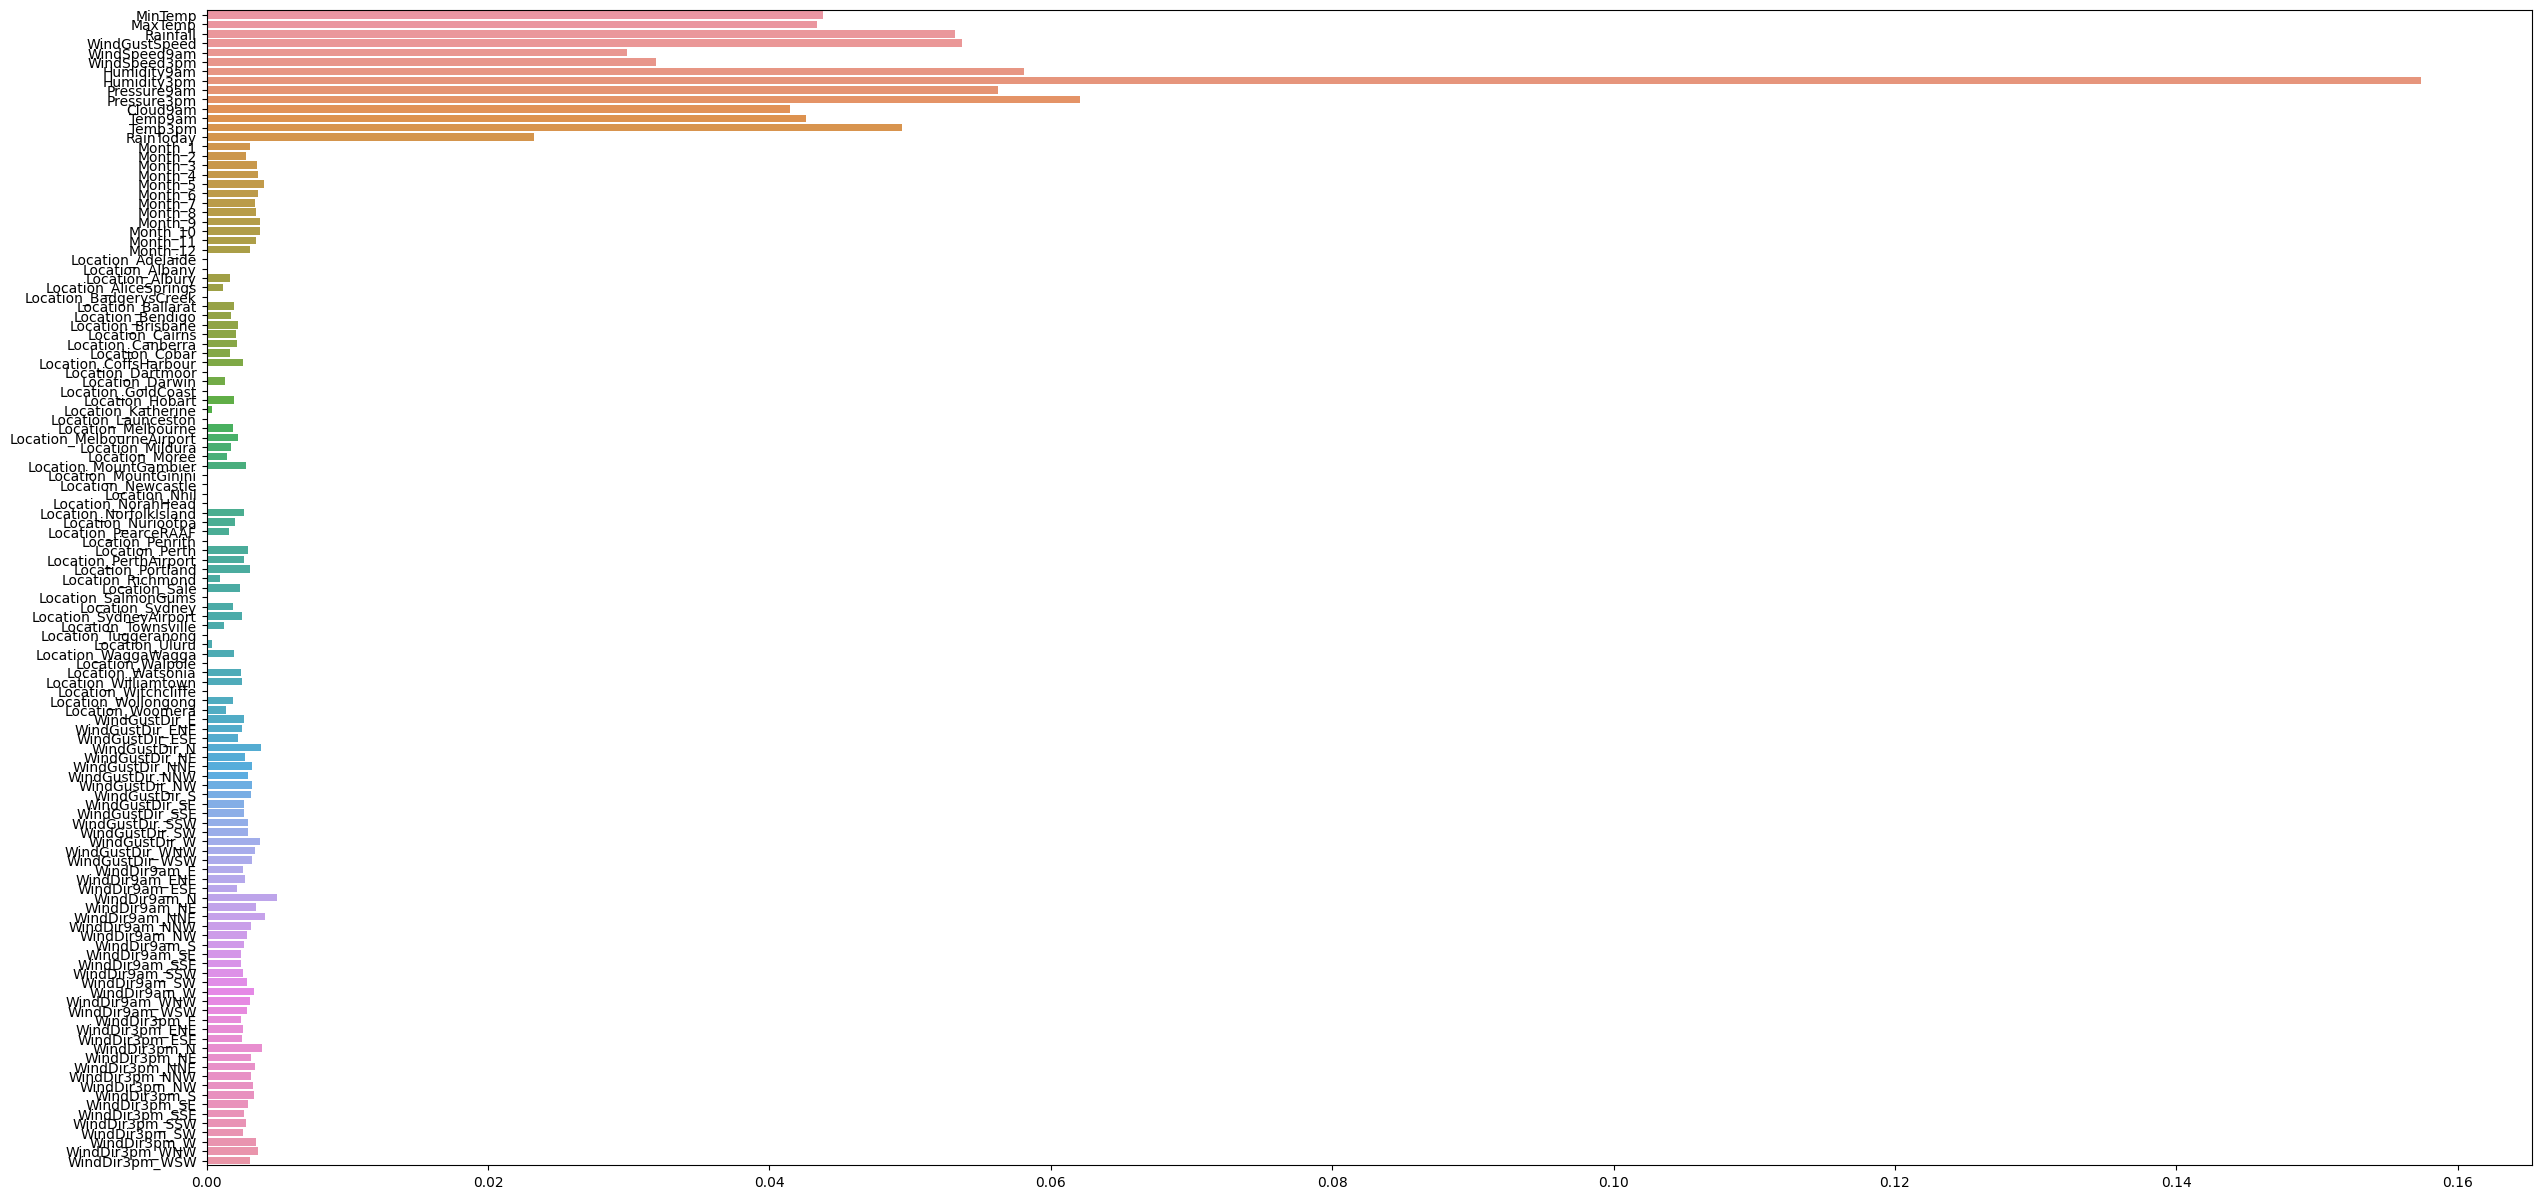

In [83]:
# Задание 4.12
# Как мы говорили в предыдущем юните, благодаря случайному лесу можно узнать, какие признаки оказывают большее влияние на целевую
# переменную по сравнению с другими.
# Оцените значимость признаков. Отметьте три признака, которые дают наибольший вклад в целевую переменную:
fig, axes = plt.subplots(1,1, figsize=(30,15))

barplot = sns.barplot(
    x=rfc.feature_importances_,
    y=rfc.feature_names_in_,
    ax=axes
)

